# Bonus

In [ ]:
from pathlib import Path
import numpy as np
from gensim.models import Word2Vec, FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from training.abstract_trainer import Split

from training.dataset import Dataset
from training.transforms import RemovePunctuation, RemoveStopWords, ToLower, CyrToLat, StemSerbian, Transform
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42

In [ ]:
# loading dataset
data_path = Path("./dataset_updated.csv")

COLUMNS = ["Opsti utisak film", "Radnja", "Rezija", "Gluma","Muzika",
           "Opsti utisak komentar", "Specijalni efekti"]

COLUMNS_FOR_INFERENCE = ["Opsti utisak film", "Gluma", "Opsti utisak komentar"]

data = Dataset([data_path], "None", label_names=COLUMNS)

In [ ]:
# preprocess dataset (apply transformations)

transformations = Transform([CyrToLat, RemovePunctuation, ToLower, RemoveStopWords])

transformed_data = transformations(data)
comments, labels = transformed_data.to_numpy()

empty = comments == ""
comments = comments[~empty]
labels = labels[~empty]

In [ ]:
# init embedder
comments_for_embedding = [comment.split() for comment in comments]
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(comments)]
embedder = Word2Vec(sentences=comments_for_embedding, workers=2, vector_size=256, min_count=0)
embedder_fast_text = FastText(sentences=comments, workers=2, vector_size=256, min_count=0)
embedder_doc = Doc2Vec(documents=documents, workers=2, vector_size=128, min_count=0)

In [ ]:
labels = labels[:, [0, 3, 5]]

In [ ]:
mapping_to_labels = {"None": 0., "Positive": 1., "Negative": 2., "Neutral": 3.}

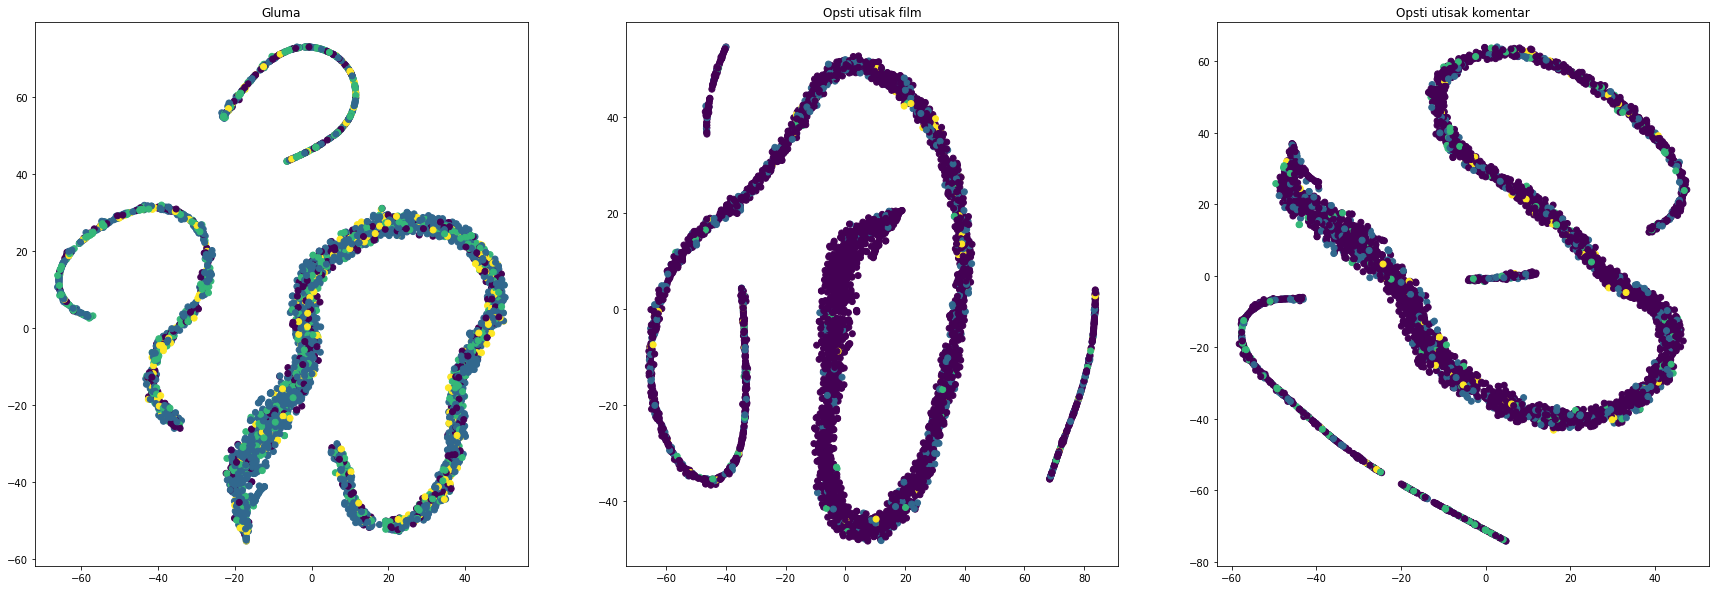

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = labels.shape[1], figsize=(30, 10))
for i, (axis, column_label) in enumerate(zip(axes, labels.T)):
    label_column = np.array([mapping_to_labels[label] for label in column_label])
    doc_vecs = np.vstack([embedder_doc.infer_vector(comment.split()) for comment in comments])
    tsne = TSNE(n_components=2)
    fets_2d = tsne.fit_transform(doc_vecs)
    axis.scatter(fets_2d[:, 0], fets_2d[:, 1], c=label_column)
    axis.set_title(SENTIMENT_GROUPS[i])

In [ ]:
# create Dataset class for training
class CommentsDataset():
    def __init__(self, embedder: Doc2Vec, comments: List[str], labels: List[int], device: str):
        self._embedder = embedder
        self._comments = [comment.split() for comment in comments]
        self._device = device
        num_unique_labels = len(np.unique(labels))
        self._one_hot_labels = np.zeros((len(labels), num_unique_labels), dtype=np.float32)
        self._one_hot_labels[np.arange(len(labels)), labels] = 1.
    
    def __len__(self):
        return len(self._comments)
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        wv_representation = self._embedder.infer_vector(self._comments[idx])
        representations = torch.tensor(wv_representation).to(dtype=torch.float32, device = self._device)
        labels = torch.tensor(self._one_hot_labels[idx]).to(dtype=torch.float32, device=self._device)
        return representations, labels

In [ ]:
# define MLP

class MLP(nn.Module):
    """MLP with only linear and dropout layers."""

    def __init__(self, input_dim: int, intermediate_dim: List[int], output_dim: int):
        """Base and only constructor of MLP.

        Dropout is added after each linear layer.

        Args:
            input_dim (int): size of input data.
            intermediate_dim (List[int]): number of neurons in middle FC layers.
            output_dim (int): size of target data.
        """
        super().__init__()

        layers = []
        if len(intermediate_dim) == 0:
            layers.append(nn.Linear(input_dim, output_dim))
        else:
            num_neurons = [input_dim] + intermediate_dim
            for prev, curr in zip(num_neurons[:-1], num_neurons[1:]):
                layers.append(nn.Linear(prev, curr))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(0.1))

            layers.append(nn.Linear(num_neurons[-1], output_dim))

        self._net = nn.Sequential(*layers)

    def __getitem__(self, index):
        """Getter for layers."""
        return self._net[index]

    def forward(self, x):
        """Definition of forward pass."""
        output = self._net(x)

        return output

In [ ]:
models = {}
splits = {}
losses = {}
metrics = {}
confusion_mats = {}

confusion_mat_labels = ["None", "Postiive", "Negative", "Neutral"]

n_epochs = 10
for i, column in enumerate(COLUMNS_FOR_INFERENCE):
    print(f"Class: {column}")
    labels_column = labels[:, i].copy()
    labels_column = np.array([mapping_to_labels[label] for label in labels_column])
    train_text, test_text, train_labels, test_labels = train_test_split(comments, labels_column, test_size=0.2, stratify=labels_column)
    splits[column] = Split(train_text, test_text, train_labels, test_labels)

    labels_unique, counts = np.unique(train_labels, return_counts=True)
    class_weights = [sum(counts) / c for c in counts]
    label_weights = [class_weights[int(label)] for label in train_labels]

    # intitialize_model
    column_model = MLP(128, [128, 32], output_dim=4)
    column_model.train()
    # training:

    optimizer = torch.optim.AdamW(lr=0.1, params=column_model.parameters())
    loss_module = torch.nn.CrossEntropyLoss()

    # initialize dataset

    column_dataset = CommentsDataset(embedder_doc, train_text.tolist(), train_labels.astype(int), "cpu")

    # initialize loader
    sampler = torch.utils.data.WeightedRandomSampler(label_weights, len(train_labels))

    column_loader = torch.utils.data.DataLoader(column_dataset, batch_size=256, sampler=sampler, shuffle=False)

    losses[column] = []

    # training loop
    for epoch_cnt in range(n_epochs):
        print(f"Epoch: {epoch_cnt}")
        for batch_cnt, (feature, gt) in enumerate(column_loader):
            optimizer.zero_grad()
            pred = column_model(feature)
            loss = loss_module(pred, gt)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                losses[column].append(loss.mean().item())
    
    models[column] = column_model

    # testing

    model = models[column]
    model.eval()

    # initialize dataset

    column_test_dataset = CommentsDataset(embedder_doc, test_text.tolist(), test_labels.astype(int), "cpu")

    # initialize loader

    column_test_loader = torch.utils.data.DataLoader(column_test_dataset, batch_size=len(test_labels), shuffle=False)

    test_features, test_gt = next(iter(column_test_loader))

    with torch.no_grad():
        pred = column_model(test_features)
        _, pred_class_labels = torch.max(pred, dim=1)
    
    pred_class_labels_np = pred_class_labels.numpy()

    score = f1_score(test_labels, pred_class_labels_np, average="macro")
    metrics[column] = score
    confusion_mat_disp = ConfusionMatrixDisplay.from_predictions(test_labels,
                                                                 pred_class_labels_np,
                                                                 display_labels=confusion_mat_labels)
    confusion_mat_disp.ax_.set_title(column)
    plt.close(confusion_mat_disp.figure_)
    confusion_mats[column] = confusion_mat_disp

Class: Opsti utisak film
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Class: Gluma
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Class: Opsti utisak komentar
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


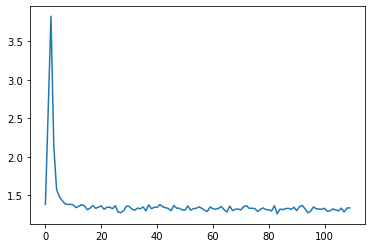

In [ ]:
plt.plot(losses["Gluma"])

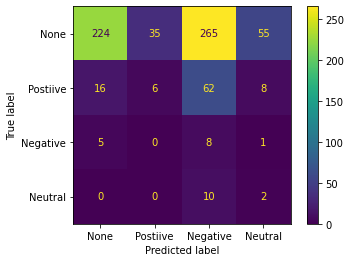

In [ ]:
confusion_mats["Gluma"].plot()